In [1]:
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

C:\Users\atle_\AppData\Roaming\Python\Python312\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# @title Download and normalize data
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

# we are going to normalize the images so their pixel values mostly fall between 0 and 1
# this is helpful if you have images on a variety of scales
# we will also return the images as float32 <- the data type that is fast for GPU computation
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)


imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

Plot a random training image and its masks. Note the masks are labels from 1, ... to the number of cells.

there are 99 cells in this image


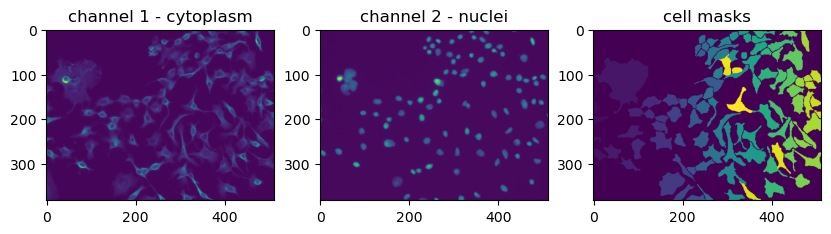

In [3]:
irand = np.random.randint(len(imgs_train))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(imgs_train[irand][0])
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 3, 2)
plt.imshow(imgs_train[irand][1])
plt.title('channel 2 - nuclei')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('cell masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

What labels will we use? We can't use numbers like masks.
The standard approach is to create a "not-cell" and a "cell" probability map for the network to learn. Then this map is thresholded (the threshold is found with a validation set) to find cells.

In [4]:
labels_train = np.zeros((len(masks_train), 2,
                         masks_train.shape[-2],
                         masks_train.shape[-1]),
                        np.longlong)
labels_train[:, 0] = masks_train == 0
labels_train[:, 1] = masks_train > 0

labels_test = np.zeros((len(masks_test), 2,
                        masks_test.shape[-2],
                        masks_test.shape[-1]),
                       np.longlong)
labels_test[:, 0] = masks_test == 0
labels_test[:, 1] = masks_test > 0

## Create transform function for augmentations

adapted from [cellpose/transforms.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/transforms.py).

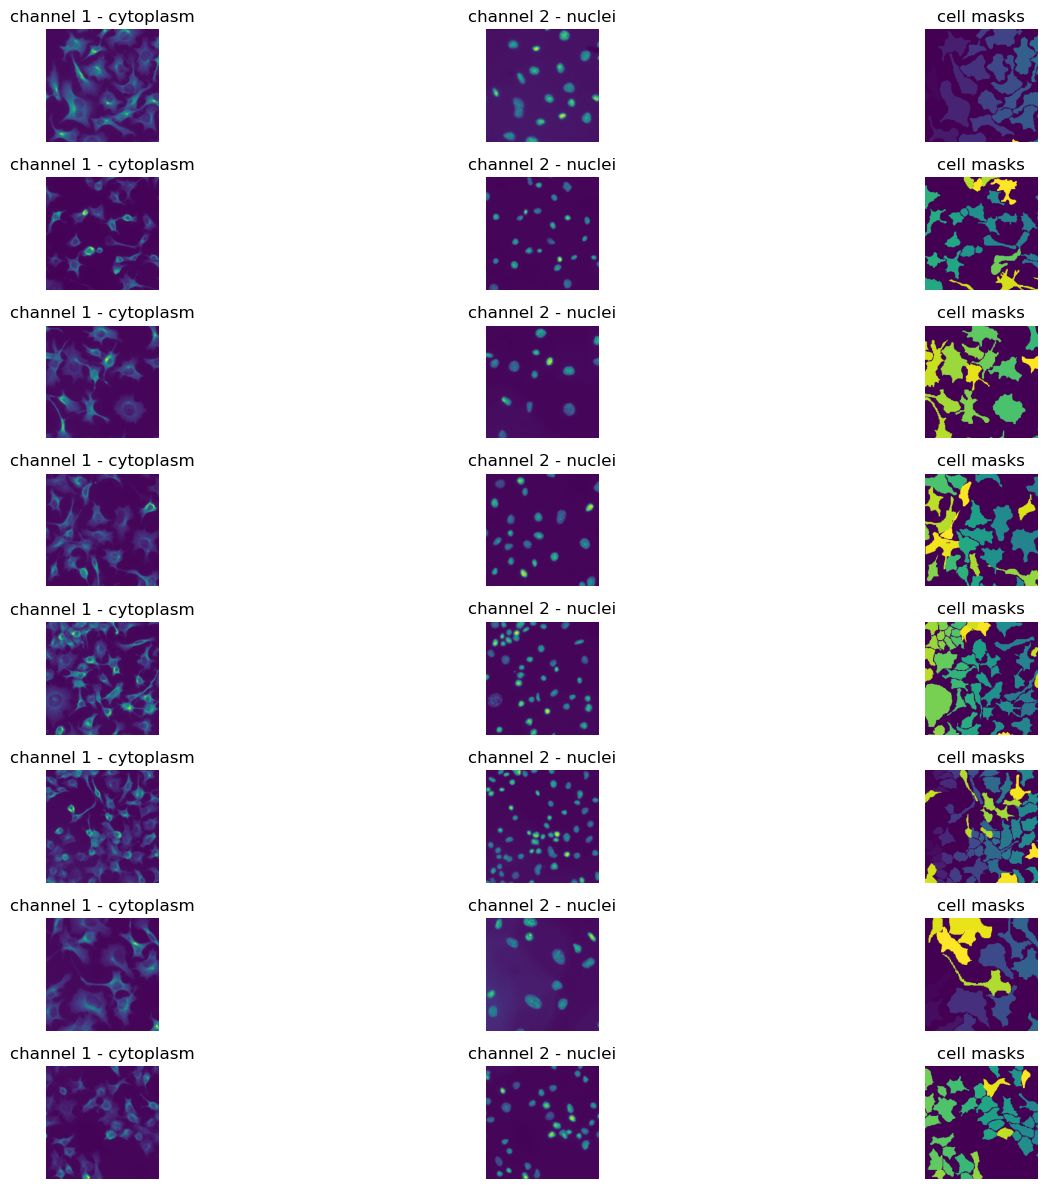

In [38]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  #xy = X[0].shape[1:]
  #print(xy)

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    """Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)"""

    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    
    # generate random scale parameter only
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    
    # create simple scaling transform
    M = np.array([[scale[n], 0, 0],
                  [0, scale[n], 0]], dtype=np.float32)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I
      #print(imgi.shape, img[:,:-1].shape)
      #imgi[n,k] = img[k, :-1]

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)
        #lbl[n,k] = labels[k, :-1]

  return imgi, lbl, scale


img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       masks_train[:8])

plt.figure(figsize=(16, 12))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 0])
  plt.title('cell masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

## Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


In [42]:
import torch
import torch.nn as nn

def convbatchrelu(in_channels, out_channels, sz):
    """
    Creates a sequential block of Conv2d -> BatchNorm2d -> ReLU.
    
    This is a common building block in deep neural networks that applies:
    1. 2D convolution with same padding to preserve spatial dimensions
    2. Batch normalization for training stability
    3. ReLU activation for non-linearity
    
    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        sz (int): Kernel size for the convolution
        
    Returns:
        nn.Sequential: Sequential container with Conv2d, BatchNorm2d, and ReLU
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
        nn.BatchNorm2d(out_channels, eps=1e-5),
        nn.ReLU(inplace=True),
    )


class convdown(nn.Module):
    """
    Downsampling convolutional block that applies two consecutive convbatchrelu blocks.
    
    This is used in the encoder (downsampling) path of the U-Net to extract features
    while maintaining the same spatial resolution within each level.
    """
    
    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Initialize the convdown block.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
            kernel_size (int): Kernel size for convolutions
        """
        super().__init__()
        self.conv = nn.Sequential()
        
        # Add two convbatchrelu blocks
        for t in range(2):
            if t == 0:
                # First conv: input_channels -> output_channels
                self.conv.add_module('conv_%d'%t,
                                   convbatchrelu(in_channels,
                                               out_channels,
                                               kernel_size))
            else:
                # Second conv: output_channels -> output_channels
                self.conv.add_module('conv_%d'%t,
                                   convbatchrelu(out_channels,
                                               out_channels,
                                               kernel_size))

    def forward(self, x):
        """
        Forward pass through both convolution blocks.
        
        Args:
            x (torch.Tensor): Input tensor
            
        Returns:
            torch.Tensor: Output after two convolution blocks
        """
        x = self.conv[0](x)
        x = self.conv[1](x)
        return x


class downsample(nn.Module):
    """
    Encoder path of the U-Net that progressively downsamples the input.
    
    Creates multiple levels of feature extraction, where each level:
    1. Applies convdown to extract features
    2. Uses max pooling to reduce spatial dimensions for the next level
    """
    
    def __init__(self, nbase, kernel_size):
        """
        Initialize the downsampling path.
        
        Args:
            nbase (list): List of channel numbers for each level [input_ch, level1_ch, level2_ch, ...]
            kernel_size (int): Kernel size for all convolutions
        """
        super().__init__()
        self.down = nn.Sequential()
        self.maxpool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by factor of 2
        
        # Create convdown blocks for each level transition
        for n in range(len(nbase) - 1):
            self.down.add_module('conv_down_%d'%n,
                               convdown(nbase[n],
                                      nbase[n + 1],
                                      kernel_size))

    def forward(self, x):
        """
        Forward pass through the encoder path.
        
        Args:
            x (torch.Tensor): Input image tensor
            
        Returns:
            list: List of feature maps from each level (for skip connections)
        """
        xd = []
        for n in range(len(self.down)):
            if n > 0:
                # Apply max pooling to previous level's output
                y = self.maxpool(xd[n - 1])
            else:
                # First level uses original input
                y = x
            # Apply convdown block and store result
            xd.append(self.down[n](y))
        return xd


class convup(nn.Module):
    """
    Upsampling convolutional block for the decoder path.
    
    Combines upsampled features with skip connection features from the encoder
    and applies two convolution blocks.
    """
    
    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Initialize the convup block.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
            kernel_size (int): Kernel size for convolutions
        """
        super().__init__()
        self.conv = nn.Sequential()
        self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                   out_channels,
                                                   kernel_size))
        self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                   out_channels,
                                                   kernel_size))

    def forward(self, x, y):
        """
        Forward pass combining upsampled features with skip connections.
        
        Args:
            x (torch.Tensor): Upsampled features from previous decoder level
            y (torch.Tensor): Skip connection features from corresponding encoder level
            
        Returns:
            torch.Tensor: Combined and processed features
        """
        x = self.conv[0](x)
        x = self.conv[1](x + y)  # Skip connection: element-wise addition
        return x


class upsample(nn.Module):
    """
    Decoder path of the U-Net that progressively upsamples features.
    
    Uses skip connections from the encoder path to recover spatial information
    lost during downsampling.
    """
    
    def __init__(self, nbase, kernel_size):
        """
        Initialize the upsampling path.
        
        Args:
            nbase (list): List of channel numbers for each level (reverse order of encoder)
            kernel_size (int): Kernel size for all convolutions
        """
        super().__init__()
        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')  # 2x spatial upsampling
        self.up = nn.Sequential()
        
        # Create convup blocks for each level (reverse order)
        for n in range(len(nbase) - 1, 0, -1):
            self.up.add_module('conv_up_%d'%(n - 1),
                             convup(nbase[n], nbase[n - 1], kernel_size))

    def forward(self, xd):
        """
        Forward pass through the decoder path.
        
        Args:
            xd (list): List of encoder feature maps (for skip connections)
            
        Returns:
            torch.Tensor: Final upsampled feature map
        """
        x = xd[-1]  # Start with deepest (most downsampled) features
        
        for n in range(0, len(self.up)):
            if n > 0:
                # Upsample spatial dimensions
                x = self.upsampling(x)
            # Combine with corresponding encoder features via skip connection
            x = self.up[n](x, xd[len(xd) - 1 - n])
        return x


class Unet(nn.Module):
    """
    Complete U-Net architecture for image segmentation.
    
    U-Net consists of:
    1. Encoder path (downsample): Extracts hierarchical features
    2. Decoder path (upsample): Reconstructs spatial resolution using skip connections
    3. Final output layer: Produces segmentation map
    
    The skip connections between encoder and decoder help recover fine-grained
    spatial information lost during downsampling.
    """
    
    def __init__(self, nbase, nout, kernel_size):
        """
        Initialize the U-Net model.
        
        Args:
            nbase (list): Channel configuration [input_channels, level1, level2, ..., bottleneck]
            nout (int): Number of output classes/channels
            kernel_size (int): Kernel size for all convolutions
            
        Example:
            nbase = [1, 64, 128, 256, 512] for a 4-level U-Net with 1 input channel
            nout = 2 for binary segmentation
        """
        super(Unet, self).__init__()
        self.nbase = nbase
        self.nout = nout
        self.kernel_size = kernel_size
        
        # Encoder path
        self.downsample = downsample(nbase, kernel_size)
        
        # Decoder path configuration (skip the input level, add bottleneck level)
        nbaseup = nbase[1:]  # Remove input channels
        nbaseup.append(nbase[-1])  # Add bottleneck channels
        self.upsample = upsample(nbaseup, kernel_size)
        
        # Final output convolution to produce segmentation map
        self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                              padding=kernel_size//2)

    def forward(self, data):
        """
        Forward pass through the complete U-Net.
        
        Args:
            data (torch.Tensor): Input image tensor [batch, channels, height, width]
            
        Returns:
            torch.Tensor: Segmentation output [batch, nout, height, width]
        """
        # Encoder: extract multi-scale features
        T0 = self.downsample(data)
        
        # Decoder: reconstruct with skip connections
        T0 = self.upsample(T0)
        
        # Final classification layer
        T0 = self.output(T0)
        return T0

    def save_model(self, filename):
        """
        Save model parameters to file.
        
        Args:
            filename (str): Path to save the model state dictionary
        """
        torch.save(self.state_dict(), filename)

    def load_model(self, filename, cpu=False):
        """
        Load model parameters from file.
        
        Args:
            filename (str): Path to the saved model state dictionary
            cpu (bool): If True, load model for CPU inference
            
        Note:
            The CPU loading branch has a bug - it references 'self.concatenation' 
            which doesn't exist in __init__. This should be removed or fixed.
        """
        if not cpu:
            self.load_state_dict(torch.load(filename))
        else:
            # BUG: This reinitializes the model but references non-existent self.concatenation
            self.__init__(self.nbase,
                        self.nout,
                        self.kernel_size,
                        self.concatenation)  # This line will cause an AttributeError

            self.load_state_dict(torch.load(filename,
                                          map_location=torch.device('cpu')))

# Example usage:
# model = Unet(nbase=[3, 64, 128, 256, 512], nout=1, kernel_size=3)
# This creates a U-Net with:
# - 3 input channels (RGB image)
# - 4 encoder/decoder levels with [64, 128, 256, 512] channels
# - 1 output channel (binary segmentation)
# - 3x3 convolution kernels throughout

### Define the network

In [43]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

### Train the network

Here we've implemented code to train the network.

Note we probably should be evaluating test performance throughout training -- implement that yourself.

In [44]:
from datetime import datetime

# train the network
# parameters related to training the network
batch_size = 8 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
### you will want to increase n_epochs!
n_epochs = 2  # number of times to cycle through all the data during training
learning_rate = 0.1 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 25 # how often to save the network
val_frac = 0.05 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

# split into train and validation datasets
n_val = int(len(imgs_train) * val_frac)
n_train = len(imgs_train) - n_val
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train))
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = labels_train[iperm[:n_train]], labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)
# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
    # loop through each batch in the training data
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      train_data = train_data.astype(np.float32)
      train_labels = train_labels.astype(np.float32)
      imgs, lbls, _ = random_rotate_and_resize(train_data[inds],
                                               train_labels[inds])

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)
      lbls = lbls.long()

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 1])
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    epoch_losses[epoch] = epoch_loss
    pbar.set_postfix(**{'loss (epoch)': epoch_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/2: 100%|██████████| 77/77 [00:39<00:00,  1.95img/s, loss (epoch)=7.77] 



Saving network state at epoch 1


Epoch 2/2: 100%|██████████| 77/77 [00:39<00:00,  1.93img/s, loss (epoch)=4.07] 


Saving network state at epoch 2
